# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel, DD03SpeciationModel
import paraspec.taxon_lineage as txl

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=100, pop_size = 10):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    elevation = X + r.rand(*Y.shape)
    if trait_comp:
        model = DD03SpeciationModel(X, Y, pop_size, car_cap_max=500, 
                                sigma_opt_trait=0.2, mut_prob=0.05, sigma_mut=0.05,
                                sigma_mov=5, sigma_comp_trait=0.9, sigma_comp_dist=0.1, 
                                random_seed=1234)
    else:
        model = IR12SpeciationModel(X, Y, pop_size,
                                nb_radius=50, car_cap=50,
                                sigma_w=0.2, sigma_mov=5, sigma_mut=0.05,
                                lifespan=1, mut_prob=0.05, random_seed=1234)

    model.initialize([[0.5, 0.5]])
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(elevation, elevation.min(), elevation.max(), 1)
        dfs.append(model.to_dataframe())
        model.update_individuals(1)
    return pd.concat(dfs).reset_index(drop=True), elevation, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

## Phylogeny for a speciation model without trait-mediated competition

In [4]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

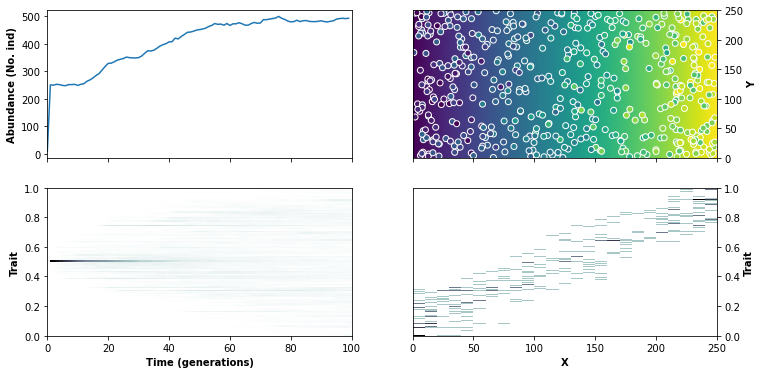

In [5]:
plot_sol(ind_dtf1, elevation1, X1)

In [6]:
dtf_out1 = txl.taxon_definition(ind_dtf1)
dtf_out1

,step,time,dt,id,parent,x,y,r_d,opt_trait,fitness,n_offspring,trait_0,taxon_id,ancestor_id
0,0,0.0,0.0,0,0,110.251531,15.034664,50.000000,0.444406,0.962103,48,0.500000,1,0
1,0,0.0,0.0,1,1,152.467702,170.922227,50.000000,0.600738,0.880864,44,0.500000,1,0
2,0,0.0,0.0,2,2,215.905324,167.809505,25.000000,0.845671,0.224561,6,0.500000,1,0
3,0,0.0,0.0,3,3,215.939418,152.754495,25.000000,0.844245,0.227340,6,0.500000,1,0
4,0,0.0,0.0,4,4,168.720328,15.034328,50.000000,0.667795,0.703322,35,0.500000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40490,99,99.0,0.0,40490,39997,50.067842,4.060274,1.136364,0.217350,0.906405,1,0.306015,1347,1332
40491,99,99.0,0.0,40491,39998,41.982479,37.866272,0.892857,0.184139,0.976277,1,0.227964,1347,1332
40492,99,99.0,0.0,40492,39999,56.706385,16.585954,0.925926,0.243719,0.944841,1,0.311092,1347,1332
40493,99,99.0,0.0,40493,40000,37.499168,27.003395,0.961538,0.168529,0.784309,1,0.307943,1347,1332


In [7]:
taxon_lineage1 = txl.dtf_taxon(dtf_out1)
taxon_lineage1

,time,id,parent,trait_0,abundance,node_type,branch_length
0,0.0,1,0,0.500000,10,root,0.001
1,1.0,2,1,0.499174,251,node,1.001
2,2.0,3,2,0.499883,250,node,1.001
3,3.0,4,3,0.500391,253,node,1.001
4,4.0,5,4,0.500080,252,node,1.001
...,...,...,...,...,...,...,...
1353,99.0,1354,1328,0.564059,5,leaf,0.001
1354,99.0,1355,1321,0.172931,14,leaf,0.001
1355,99.0,1356,1322,0.539072,23,leaf,0.001
1356,99.0,1357,1324,0.095446,47,leaf,0.001


(-1979.272065, 21166.519065, -1967.55, 20913.55)

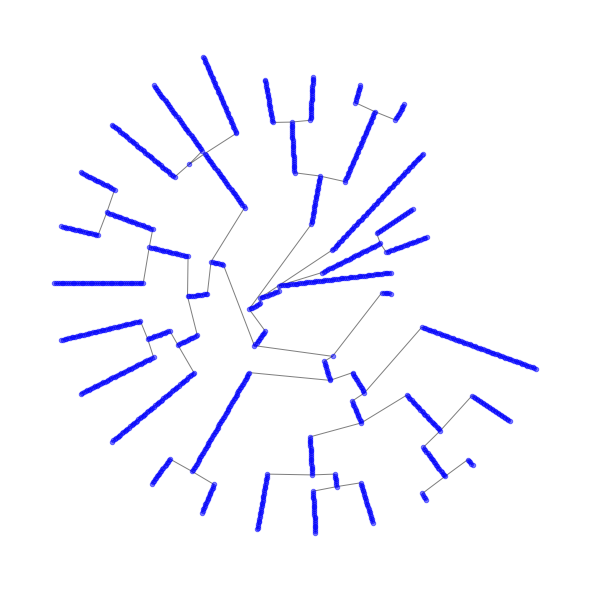

In [8]:
G = (taxon_lineage1
     .ptree.to_networkx(node_col='trait_0'))

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, node_size=20, alpha=0.5, node_color="blue")
plt.axis("equal")

In [9]:
tree1 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage1)

In [10]:
tree1.as_string(schema='newick')

'(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((1333:1.001)node:1.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001,(((((((((((((((((1339:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)nod

In [11]:
tree1.print_plot()

                                                            /+++++++++++++ 1333
            /++++++++++++++++++++++++++++++++++++++++++++++++                  
            |                                               \+++++++++++++ 1339
            |                                                                  
            |                                     ++++++++++++++++++++++++ 1353
            |                    /+++++++++++++++++                            
   /+++++++++                    |                |     ++++++++++++++++++ 1346
   |        |                    |                +++++++                      
   |        |          +++++++++++                      ++++++++++++++++++ 1357
   |        |          |         |                                             
   |        |          |         |                                    /+++ 1344
   |        |          |         |                    /++++++++++++++++        
   |        \+++++++++++         \++++++

## Phylogeny for a speciation model with trait-mediated competition

In [12]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

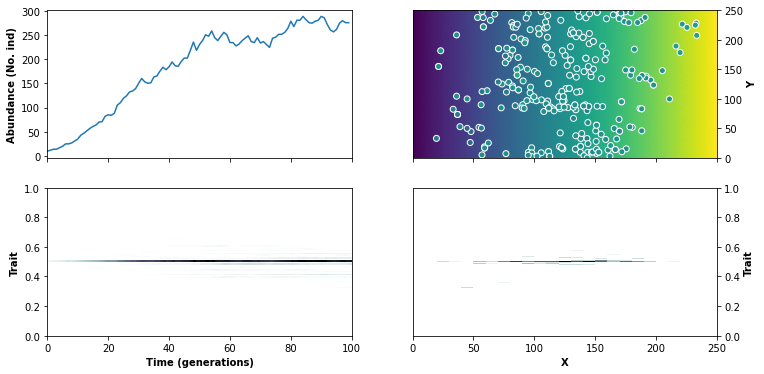

In [13]:
plot_sol(ind_dtf2, elevation2, X2)

In [14]:
dtf_out2 = txl.taxon_definition(ind_dtf2)
dtf_out2

,step,time,dt,id,parent,x,y,events_i,death_i,n_offspring,trait_0,taxon_id,ancestor_id
0,0,0.0,0.0,0,0,110.251531,15.034664,M,0.035989,1,0.500000,1,0
1,0,0.0,0.0,1,1,152.467702,170.922227,M,0.039923,1,0.500000,1,0
2,0,0.0,0.0,2,2,215.905324,167.809505,M,0.270010,1,0.500000,1,0
3,0,0.0,0.0,3,3,215.939418,152.754495,M,0.275375,1,0.500000,1,0
4,0,0.0,0.0,4,4,168.720328,15.034328,B,0.049301,2,0.500000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18301,99,99.0,1.0,2618,2566,170.015207,45.180855,D,1.273287,0,0.469255,345,332
18302,99,99.0,1.0,2619,2574,166.561941,14.069323,M,1.146262,1,0.504222,345,332
18303,99,99.0,1.0,2620,2576,36.936797,73.562421,M,0.722872,1,0.416747,342,327
18304,99,99.0,1.0,2621,2577,140.521567,87.817044,M,1.160928,1,0.500000,342,327


In [15]:
taxon_lineage2 = txl.dtf_taxon(dtf_out2)
taxon_lineage2

,time,id,parent,trait_0,abundance,node_type,branch_length
0,0.0,1,0,0.500000,10,root,0.001
1,1.0,2,1,0.500000,12,node,1.001
2,2.0,3,2,0.500000,14,node,1.001
3,3.0,4,3,0.500000,14,node,1.001
4,4.0,5,4,0.500000,17,node,1.001
...,...,...,...,...,...,...,...
344,99.0,345,332,0.498643,20,leaf,0.001
345,99.0,346,331,0.512217,13,leaf,0.001
346,99.0,347,335,0.484888,42,leaf,0.001
347,99.0,348,333,0.501915,28,leaf,0.001


(-718.017, 7867.417, -732.4875, 7915.9875)

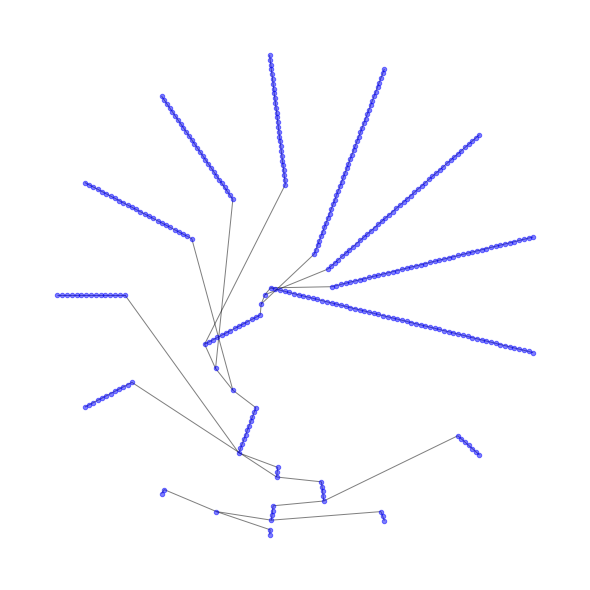

In [16]:
G = (taxon_lineage2
     .ptree.to_networkx(node_col='trait_0'))

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, node_size=20, alpha=0.5, node_color="blue")
plt.axis("equal")

In [17]:
tree2 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage2)

In [18]:
tree2.as_string(schema='newick')

'(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((344:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:1.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:1.001,(((((((((((((((((((((((((((((((((((((((((((347:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:1.001)node:1.001)node:0.001)node:0.001)node:1.001)node:1.001)n

In [19]:
tree2.print_plot()

                                         /+++++++++++++++++++++++++++++++++ 344
                                         |                                     
++++++++++++++++++++++++++++++++++++++++++/++++++++++++++++++++++++++++++++ 347
                                         ||                                    
                                         \+++++++++++++++++++++++++++++++++ 339
                                          ||                                   
                                          \+         /+++++++++++++++++++++ 340
                                           |         |                         
                                           +++++++++++/++++++++++++++++++++ 343
                                                     ||                        
                                                     \+/+++++++++++++++++++ 349
                                                      ||                       
                                        